In [56]:
import pandas as pd
import os

In [57]:
exp_path = os.path.join("experiments", "experiment_results_17022025125138", "credit_risk")

cluster_path = os.path.join(exp_path, "xper_values", "test_xper_clusters.csv")
data_path = os.path.join(exp_path, "data", "full_dataset.csv")


df_clusters = pd.read_csv(cluster_path, index_col=0)["Cluster"]
df = pd.read_csv(data_path, index_col=0)

In [58]:
df = df.merge(df_clusters, how="inner", left_index=True, right_index=True)

In [59]:
df_cluster0 = df[df["Cluster"] == 0].drop(columns=['Cluster'])
df_cluster1 = df[df["Cluster"] == 1].drop(columns=['Cluster'])


In [60]:

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

def plot_features_by_class(df_clusters):
    # --- 1) Identify features (excluding "Default (y)" and "Cluster") ---
    #     Adjust to match your actual DataFrame columns
    features = df_clusters.columns.difference(["Default (y)", "Cluster"])
    n_features = len(features)

    # --- 2) We want an extra subplot to show % default by cluster ---
    #     So we add +1 to the total number of features to plot
    total_plots = n_features + 1  
    subplots = math.ceil(total_plots / 4)

    fig, axes = plt.subplots(subplots, 4, figsize=(20, 16))
    axes = axes.flatten()

    # Distinct color palette for the default classes
    n_defaults = df_clusters["Default (y)"].nunique()
    default_palette = sns.color_palette("tab10", n_colors=n_defaults)

    # --- 3) Loop over features and plot them ---
    for i, feature in enumerate(features):
        ax = axes[i]
        
        # Replace unwanted values with NaN (no inplace=...)
        df_clusters[feature] = df_clusters[feature].replace(
            ["?", "None", "", np.inf, -np.inf], np.nan
        )
        
        # Create a cleaned copy for plotting
        df_clusters_clean = df_clusters.dropna(subset=[feature]).copy()
        df_clusters_clean = df_clusters_clean.fillna(0)
        
        # Try to convert to numeric
        df_clusters_clean[feature] = pd.to_numeric(df_clusters_clean[feature], errors="coerce")
        # Drop rows where conversion failed
        df_clusters_clean = df_clusters_clean.dropna(subset=[feature])
        
        unique_values = df_clusters_clean[feature].unique()
        
        # Decide if feature is categorical (few unique values) or continuous
        if len(unique_values) < 5:
            # ---- Categorical => bar chart of percentages by default class ----
            # Convert to integer if it’s truly categorical
            df_clusters_clean[feature] = df_clusters_clean[feature].astype(int)
            
            category_counts = (
                df_clusters_clean.groupby(["Default (y)", feature])
                .size()
                .reset_index(name="Count")
            )
            total_counts = category_counts.groupby("Default (y)")["Count"].transform("sum")
            category_counts["Percentage"] = category_counts["Count"] / total_counts * 100
            
            sns.barplot(
                data=category_counts,
                x=feature,
                y="Percentage",
                hue="Default (y)",
                palette="Reds",
                ax=ax
            )
            ax.set_ylabel("Percentage (%)")
            ax.set_xticks(sorted(df_clusters_clean[feature].unique()))
            
        else:
            # ---- Continuous => histplot + optional KDE ----
            sns.histplot(
                data=df_clusters_clean,
                x=feature,
                hue="Default (y)",
                kde=True,
                bins=30,
                palette=default_palette,
                alpha=0.6,
                ax=ax
            )
            ax.set_ylabel("Density")
            
            # Manually set legend (so only classes present appear)
            default_labels = sorted(df_clusters_clean["Default (y)"].unique())
            legend_patches = [
                mpatches.Patch(color=default_palette[j], label=f"{j}")
                for j in default_labels
            ]
            ax.legend(handles=legend_patches, title="Default (y)", loc="upper right")
        
        ax.set_title(f"{feature}")
        ax.set_xlabel(feature)
        ax.tick_params(axis="x", rotation=45)

    # --- 4) Add one extra subplot: % of default class in each cluster ---
    #     Only do this if you actually have a "Cluster" column.
    if "Cluster" in df_clusters.columns:
        i += 1  # Move to the next subplot index
        ax = axes[i]

        # Calculate percentage of default for each cluster
        df_bar = (
            df_clusters.groupby(["Cluster", "Default (y)"])
            .size()
            .reset_index(name="Count")
        )
        # Convert counts to percentage within each cluster
        df_bar["Percentage"] = df_bar.groupby("Cluster")["Count"].transform(lambda x: x / x.sum() * 100)

        # Plot
        sns.barplot(
            data=df_bar,
            x="Cluster",
            y="Percentage",
            hue="Default (y)",
            palette="viridis",
            ax=ax
        )
        ax.set_title("Default Distribution by Cluster")
        ax.set_ylabel("Percentage (%)")
        ax.tick_params(axis="x", rotation=45)

    # --- 5) Hide any leftover subplots if we didn’t use them all ---
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Feature Distributions", fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    plt.close()


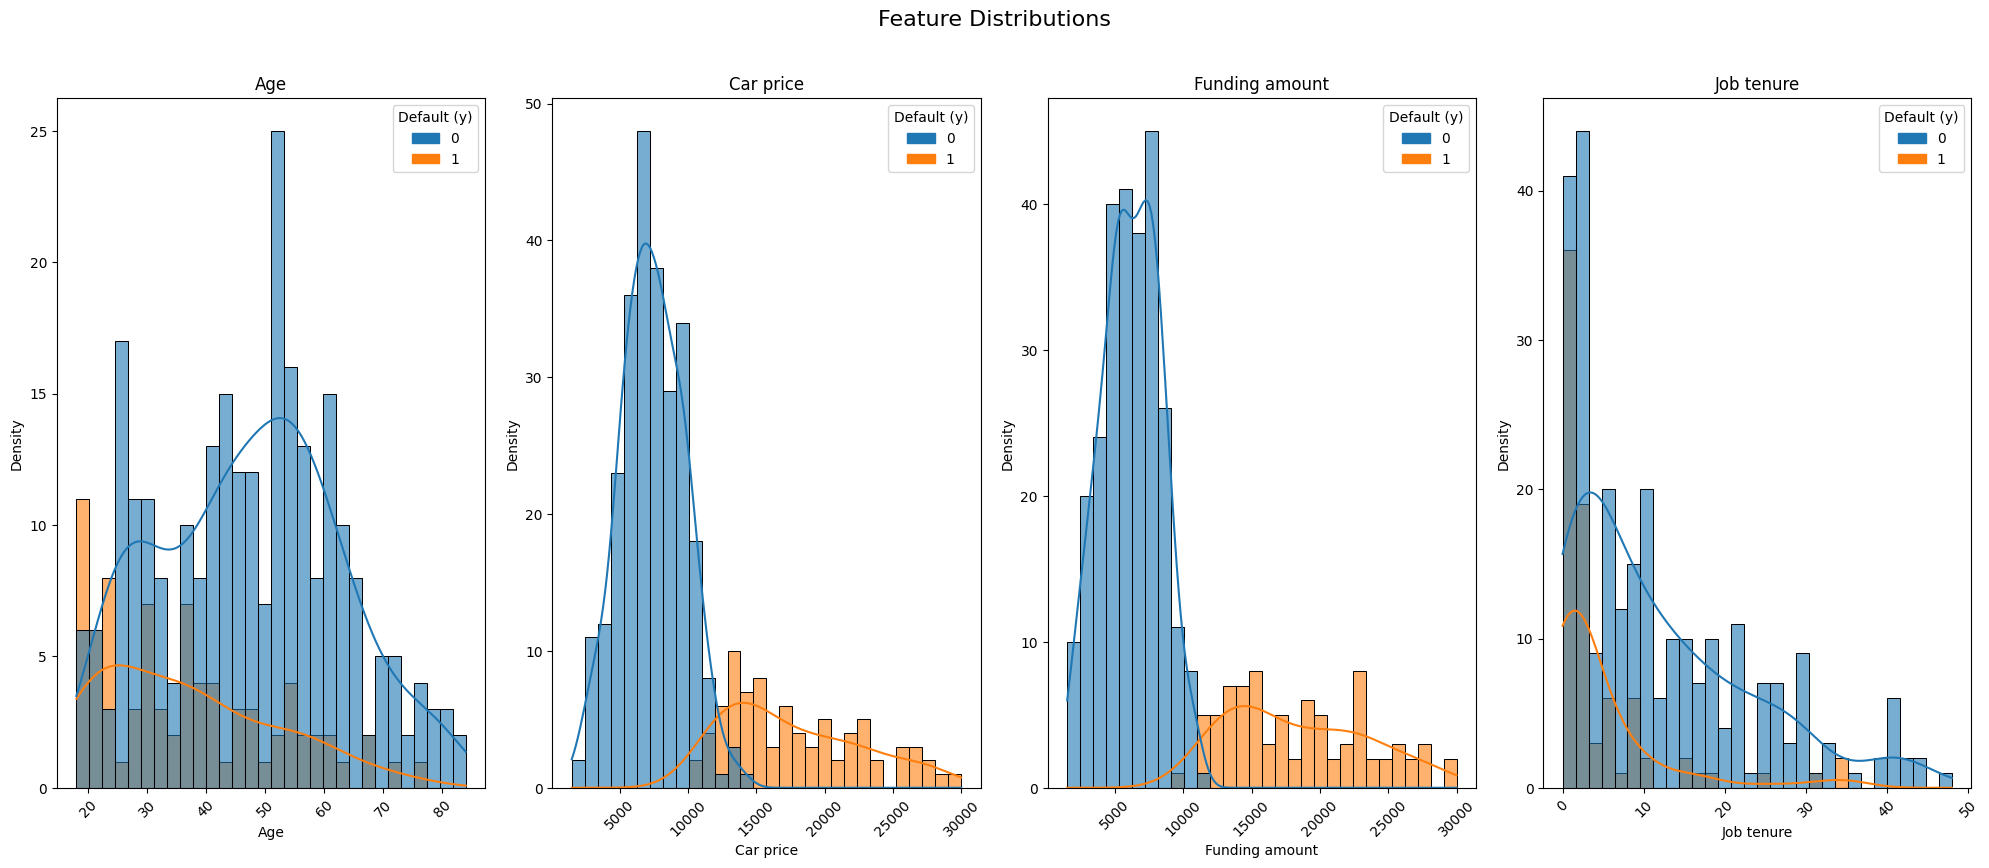

In [61]:
plot_features_by_class(df_cluster0)


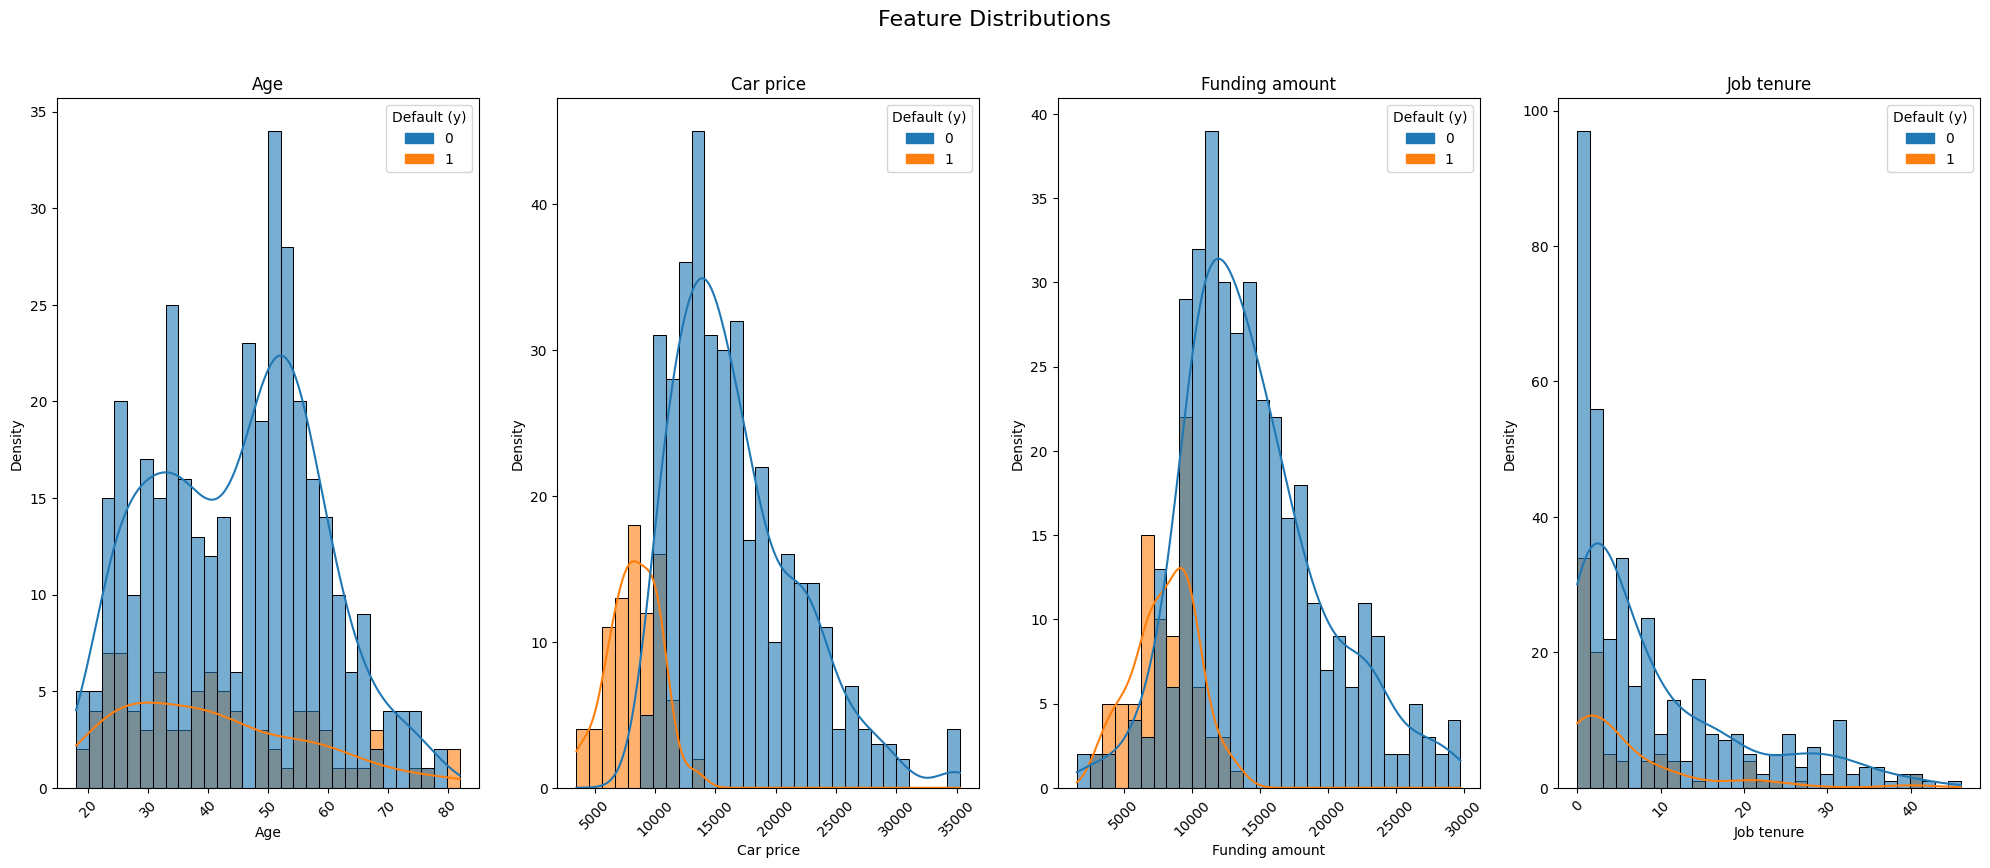

In [62]:
plot_features_by_class(df_cluster1)


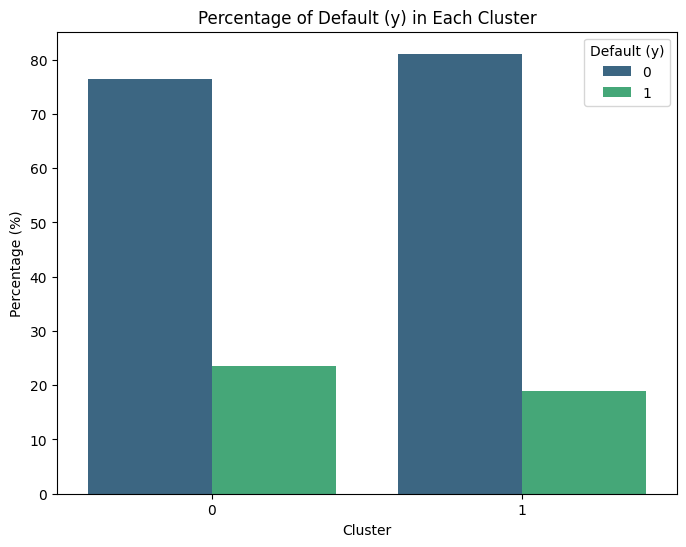

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Bar chart of Default (y) distribution by Cluster
# 1) Group and count
df_bar = (
    df
    .groupby(["Cluster", "Default (y)"])
    .size()
    .reset_index(name="Count")
)

# 2) Convert counts to percentage within each cluster
df_bar["Percentage"] = (
    df_bar
    .groupby("Cluster")["Count"]
    .transform(lambda x: x / x.sum() * 100)
)

# 3) Plot
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_bar,
    x="Cluster",
    y="Percentage",
    hue="Default (y)",
    palette="viridis"
)

plt.title("Percentage of Default (y) in Each Cluster")
plt.ylabel("Percentage (%)")
plt.xlabel("Cluster")
plt.legend(title="Default (y)", loc="best")
plt.show()
